# Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50

import warnings
warnings.filterwarnings("ignore")

2024-02-23 14:45:08.615889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 14:45:08.615984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 14:45:08.774959: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Import Data and Data Augmentation

In [2]:
def define_paths(dir):
    filepaths = []
    labels = []
    folders = os.listdir(dir)
    
    for folder in folders:
        folderpath = os.path.join(dir, folder)
        files = os.listdir(folderpath)
        
        for file in files:
            filepath = os.path.join(folderpath, file)
            filepaths.append(filepath)
            labels.append(folder)
    return (filepaths, labels)

def define_df(filepaths, labels):
    f_series = pd.Series(filepaths, name = 'filepaths')
    l_series = pd.Series(labels, name = 'labels')
    return pd.concat([f_series, l_series], axis = 1)

def get_test_df(dir):
    filepaths, labels = define_paths(dir)
    f_series = pd.Series(filepaths, name = 'filepaths')
    l_series = pd.Series(labels, name = 'labels')
    return pd.concat([f_series, l_series], axis = 1)

def split_data(dir):
    filepaths, labels = define_paths(dir)
    df = define_df(filepaths, labels)
    train_df, val_df = train_test_split(df, train_size=0.8, shuffle= True, random_state=42, stratify=df['labels'])
    return train_df, val_df

In [3]:
def scalar(img): return img

def create_model_data(train_df, val_df, test_df, batch_size = 32):
    color = 'rgb'
    img_size = (256, 256)
    img_shape = (256, 256, 3)
    
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
        
    train_datagen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    test_datagen = ImageDataGenerator(preprocessing_function= scalar)
    
    train = train_datagen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    val = test_datagen.flow_from_dataframe( val_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    test = test_datagen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size) 
    return train, test, val

# Evaluating

In [4]:
def plot_history(hist):
    plt.figure(figsize= (20, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Validation accuracy")
    
    plt.subplot(1, 2, 2)
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.title("Loss vs Validation Loss")

In [5]:
def plot_confusion_matrix(conf_matrix, class_labels):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.title('Confusion Matrix')
    plt.show()

In [6]:
def plot_classification_report(report):
    report_df = pd.DataFrame(report).transpose()
    plt.figure(figsize=(10, 5))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap=plt.cm.Reds,fmt=".2f", cbar=False)
    plt.title('Classification Report')
    plt.show()

In [7]:
data_dir = '/kaggle/input/rice-leaf-diseases/rice-leaf-diseases/train'
test_dir = '/kaggle/input/rice-leaf-diseases/rice-leaf-diseases/test'
train_df, val_df = split_data(data_dir)
test_df = get_test_df(test_dir)

batch_size = 32
train, test, val = create_model_data(train_df, test_df, val_df, batch_size)

Found 11218 validated image filenames belonging to 9 classes.
Found 3100 validated image filenames belonging to 9 classes.
Found 2805 validated image filenames belonging to 9 classes.


# Model Architecture and Model Training

In [8]:
img_size = (256, 256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train.class_indices.keys()))
base_model = ResNet50(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 42),
    Dense(class_count, activation= 'softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 24122761 (92.02 MB)
Trainable params: 24065

In [9]:
history = model.fit(x= train, epochs= 30, verbose= 0, validation_data= val, validation_steps= None, shuffle= False)

I0000 00:00:1708699556.100985      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 [==============================] - 51s 892ms/step


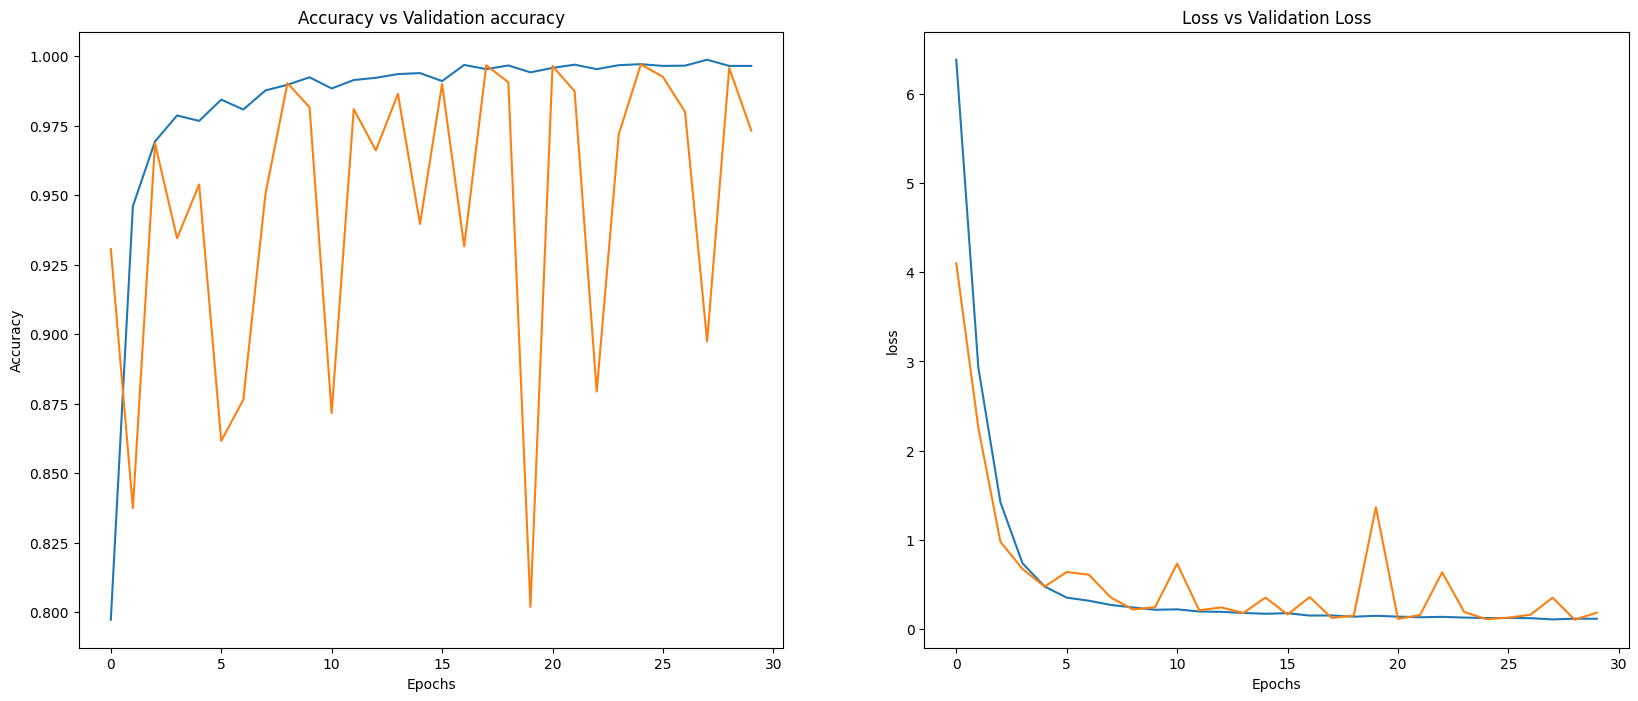

<Figure size 800x600 with 0 Axes>

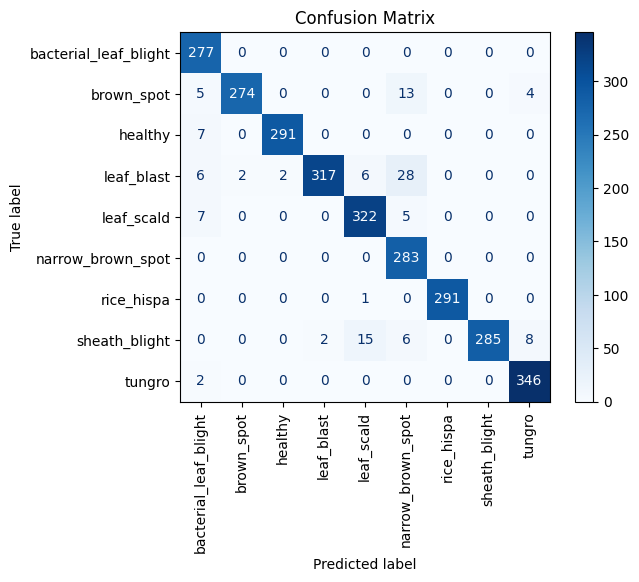

In [10]:
plot_history(history)
class_labels = list(test.class_indices.keys())
    
true_labels = test.labels
pred_probs = model.predict(test)
pred_labels = np.argmax(pred_probs, axis=1)

conf_matrix = confusion_matrix(true_labels, pred_labels)
plot_confusion_matrix(conf_matrix, class_labels)

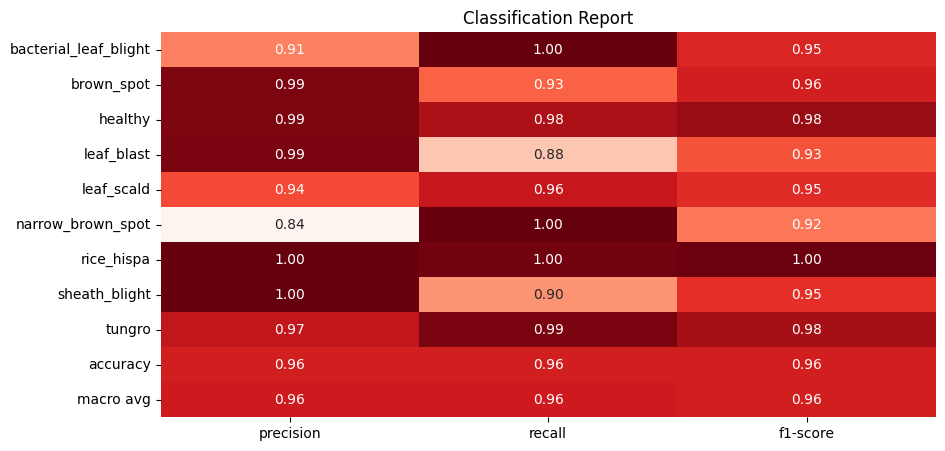

In [11]:
report = classification_report(true_labels, pred_labels, target_names=class_labels, output_dict=True)
plot_classification_report(report)

In [12]:
model.save('rice_leaf_diseases_model.h5')

# Sample Test Code

In [13]:
img_path = '/kaggle/input/rice-leaf-diseases/rice-leaf-diseases/test/tungro/IMG_0399.jpg'
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = scalar(img_array)
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
print("Predicted class:", class_labels[int(predicted_class)])

1/1 [==============================] - 2s 2s/step
Predicted class: tungro
